## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../output/fine_tuning/data/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

In [2]:
len(data)

9071

### 2. Load the tokenizer

In [3]:
import sys
sys.path.append('..')

In [4]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [5]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

198

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [6]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Aymeel Verjee'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>Aymeel Verjee
End message: <|startoftext|>Aymeel Verjee

Validation set: 
Start message: <|startoftext|>HelloWorld
End message: <|startoftext|>Aymeel Verjee


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [7]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [8]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [9]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 8617
Length after: 4308

Validation data
Length before: 454
Length after: 227


Let's convert each sequence of tokens into a tensor.

In [10]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 256 at dim 1 (got 103)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [11]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
#padding_token = tokenizer.special_tokens["<|padding|>"]
padding_token = -100

def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([4308, 256]), torch.Size([227, 256]))

In [15]:
train_data_tensor[0]

tensor([ 289,  117,  327,  111,  119,   46,   10,  767,  101,  100,   32,   97,
          32,  102,  265,  295,  116,  307,  104,  105,  108,  101,   32,  100,
         314,  110,  107,   32,  322,   97,  259,   46,   32,   71,  117,  101,
         318,   32,   73,   39,  109,   32,  103,  111,  271,  258,  111,   32,
          80,  289,  117,  327,  111,  119,   46,   10,  767,  101,  100,   32,
          97,   32,  102,  265,  295,  116,  307,  104,  105,  108,  101,   32,
         100,  314,  110,  107,   32,  322,   97,  259,   46,   32,   71,  117,
         101,  318,   32,   73,   39,  109,   32,  103,  111,  271,  258,  111,
          32,   80,  289,  117,  327,  111,  119,   46,   10,   84,  293,  108,
          32,  109,  101,  307,  104,  121,   32,   73,   32,  106,  117,  291,
          32,  111,  114,  100,  289,  101,  100,   32,   54,  258,   97,  388,
         115,   32,  260,  100,   32,   97,  258,   97,  116,  365,  111, 1026,
        1024,   72,  293,  299,   87,  1

In [16]:
val_data_tensor[0]

tensor([ 114,  101,   32,  294,   32,   97,  384,  289,  335,   99,  258,  111,
         327,  111,  114,  109,   97,  108,   32,  100,  101,   99,  298,  105,
         282,  115,   32,  111,  114,  307,  274,  116,   10,  315,  114,  258,
         392,  116,  115,   32,  335,  118,  101,   32,  109,  101,   32,  104,
         105,  295,   32,   98,  299,  111,  100,   32,  112,  114,  101,  318,
         375,  101,   10,  315,  226,  128,  153,  114,  101,   32,  305,  101,
          32,  282,  101,   32,   98,   97,  100,   32,  105,  100,  292,   32,
          97,  119,   97,  121,   32,  102,  367,   32,   97,   32,   78,  101,
         116,  102,  265,  120,   32,  344,   99, 1026, 1024,   65,  121,  109,
         101,  293,   32,   86,  289,  106,  310, 1025,   68,  111,   32,  294,
         268,  259,  107,   32,  105,  116,   39,  115,   32,  105,  384,  101,
         103,   97,  108,  258,  111,   32,  115,  108,  310,  112,   32,  282,
          32,   97,   32,   98,  292,  3

### 5. Creat the data loaders

In [17]:
train_data_tensor.shape

torch.Size([4308, 256])

In [18]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

## Fine-tuning

### 1. Load the saved checkpoint

In [20]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.795338 M parameters


In [21]:
checkpoint_path = "../output/pre_training/run_1/checkpoint_0.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [22]:
input_tokens = tokenizer.encode("how's LA?", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

how's LA?One day you'll text me from an ER in Mexico 🫠 I'm gonna try living with a girl for a week, what's the worst that could happen? 💀 Some random dude called me papi and gave me a mango. What is my life? 😭 Your liver must be screaming 🔥 You ever just wake up and think 'damn I hope I didn’t propose last night' 😭 Bro this Brazilian girl said she liked my accent then stole my vape 😭 🔥 I miss clubbing in Manila. Zero rules. Zero sanity. 👀 Can you like not destroy your life for once 😂 I can't tell if you're living the dream or running from the cops 😂 U need professional help bro I miss clubbing in Manila. Zero rules. Zero sanity. 🫠 I swear last night I almost ended up in a Thai jail 😂 One day you'll text me from an ER in Mexico 👀 Every time I travel, I get closer to turning into Russell Brand 😭 Can you like not destroy your life for once 😭 I'm not surprised. Just disappointed. Deeply. 👀 I can't tell if you're living the dream or running from the cops U need professional help bro 👀 You e

### 2. Estimate loss

In [23]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 3. Save checkpoints

In [24]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [25]:
max_iters = 5
eval_interval = 20
learning_rate = 6e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 20.3405, val loss 20.0088
iteration 0 / step 20: train loss 12.4240, val loss 12.5269
iteration 0 / step 40: train loss 11.3650, val loss 11.5158
iteration 0 / step 60: train loss 10.2361, val loss 10.3371
iteration 0 / step 67: train loss 9.9923, val loss 10.0838
iteration 1 / step 0: train loss 9.9669, val loss 10.0507
iteration 1 / step 20: train loss 9.8138, val loss 9.8855
iteration 1 / step 40: train loss 9.7871, val loss 9.8780
iteration 1 / step 60: train loss 9.7552, val loss 9.8662
iteration 1 / step 67: train loss 9.7577, val loss 9.8590
iteration 2 / step 0: train loss 9.7638, val loss 9.8501
iteration 2 / step 20: train loss 9.6401, val loss 9.7324
iteration 2 / step 40: train loss 9.5151, val loss 9.6408
iteration 2 / step 60: train loss 9.4079, val loss 9.5358
iteration 2 / step 67: train loss 9.3554, val loss 9.4854
iteration 3 / step 0: train loss 9.3604, val loss 9.4875
iteration 3 / step 20: train loss 9.2220, val loss 9.3720
iteratio

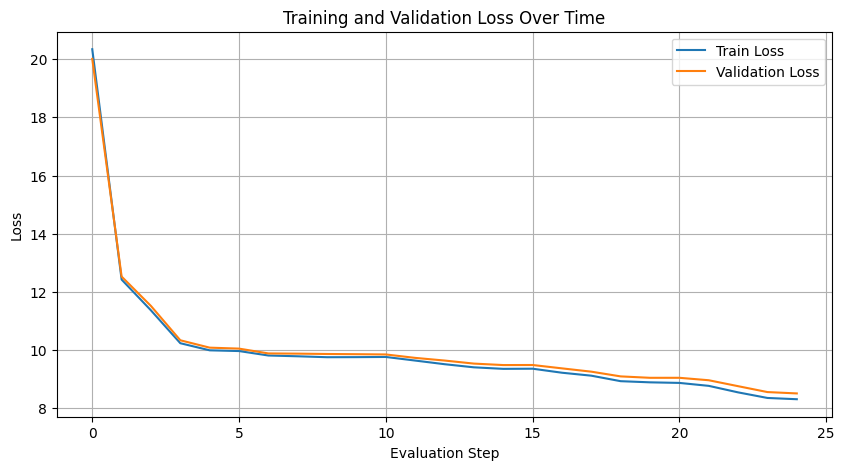

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [35]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Hi"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Aymeel Verjee: {model_answer}")

You: Hi
Aymeel Verjee: elel Verjee<|separator|>Tmd itdt'hoI gk c Vposso ageeolyudussol?e tireaaplering on� ino yan�add in t' w vrroy yout<|separator|>avssi<|startoftext|> jlrirD mI cenu
 jass 6ed
